# A/B Testing Statistical Analysis

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Set figure font size
plt.rcParams.update({'font.size': 16})

In [2]:
# Import custom class
%run -i '../src/test.py'

In [3]:
# Instantiate the class
stat_test = StatisticalTest()

# Section 1. Data Exploration

## 1.1. Load data
Here, I load the csv file as a pandas dataframe and check the size of the data

In [4]:
df = pd.read_csv('../data/rev_data.csv')
print('Data size = {}'.format(df.shape))
df.head()

Data size = (11388, 3)


,treatment,phone_os_ty,revenue_per_user
0,False,iOS,0.0007
1,True,iOS,0.1615
2,False,Android,7.9911
3,True,iOS,21.4001
4,False,iOS,1.6326


## 1.2. Data types
The data type for each column is displayed below

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11388 entries, 0 to 11387
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   treatment         11388 non-null  bool   
 1   phone_os_ty       11388 non-null  object 
 2   revenue_per_user  11388 non-null  float64
dtypes: bool(1), float64(1), object(1)
memory usage: 189.2+ KB


## 1.3. Data exploration by treatment
The distribution of average revenue-per-user (ARPU) is highly right skewed as expected, since some customers spent more than others. Therefore, I have transformed it by log base 10. The mean of ARPU in the treatment group is higher than the control group. I need to establish if the difference is statistically significant. 

In [6]:
label_pct = df.treatment.value_counts(normalize = True)*100
label = df.treatment.value_counts()
pd.DataFrame({'treatment':label.index, 'count':label.values, 'percentage':label_pct.values})

,treatment,count,percentage
0,False,5694,50.0
1,True,5694,50.0


In [7]:
print('Statistics for the treament group')
print('-'*30)
df[df.treatment == True].describe()

Statistics for the treament group
------------------------------


,revenue_per_user
count,5694.000000
mean,504.648824
std,6129.406674
min,0.000200
25%,1.113875
50%,3.135900
75%,8.748700
max,288590.197500


In [8]:
print('Statistics for the control group')
print('-'*30)
df[df.treatment == False].describe()

Statistics for the control group
------------------------------


,revenue_per_user
count,5694.000000
mean,385.739821
std,2684.739511
min,0.000100
25%,1.595100
50%,4.493850
75%,14.691825
max,89626.301700


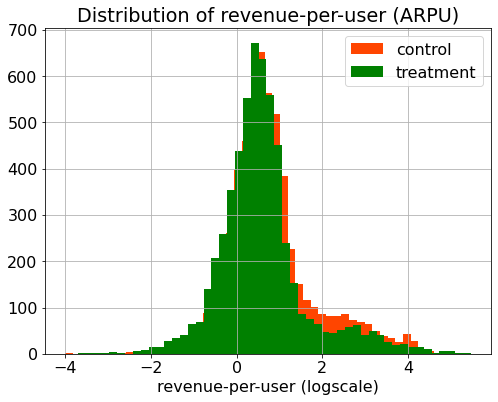

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

# Log distribution of budget and spend
np.log10(df[df.treatment == False].revenue_per_user).hist(bins = 50, ax = ax, color = 'orangered', 
                                                   label = 'control')
np.log10(df[df.treatment == True].revenue_per_user).hist(bins = 50, ax = ax, color = 'green', 
                                                               label = 'treatment')
# axes labels
plt.title('Distribution of revenue-per-user (ARPU)')
plt.xlabel('revenue-per-user (logscale)')
plt.legend(loc = 'best')
plt.savefig('../images/fig1.png')
plt.show()

## 1.4. Data exploration by segmenting phone operating systems
The distributions below show segmentation by phone operating systems within the treatment and control groups. The results show disproportionality in the number of customers and total ARPU across the phone operating systems. 

In practice, any interesting feature in the data should be investigated by invoking the Twyman's law. For instance, one might want to investigate if the new feature is compactible with different phone operating systems.

In [10]:
print('Mean revenue-per-user in the treatment & control groups')
print('-'*50)
df.pivot_table('revenue_per_user', index =['treatment','phone_os_ty'], aggfunc = 'mean')

Mean revenue-per-user in the treatment & control groups
--------------------------------------------------


revenue_per_user
treatment phone_os_ty                  
False     Android            698.275112
          Windows            199.867440
          iOS                236.129597
True      Android            643.610171
          Windows            337.548460
          iOS                460.594163

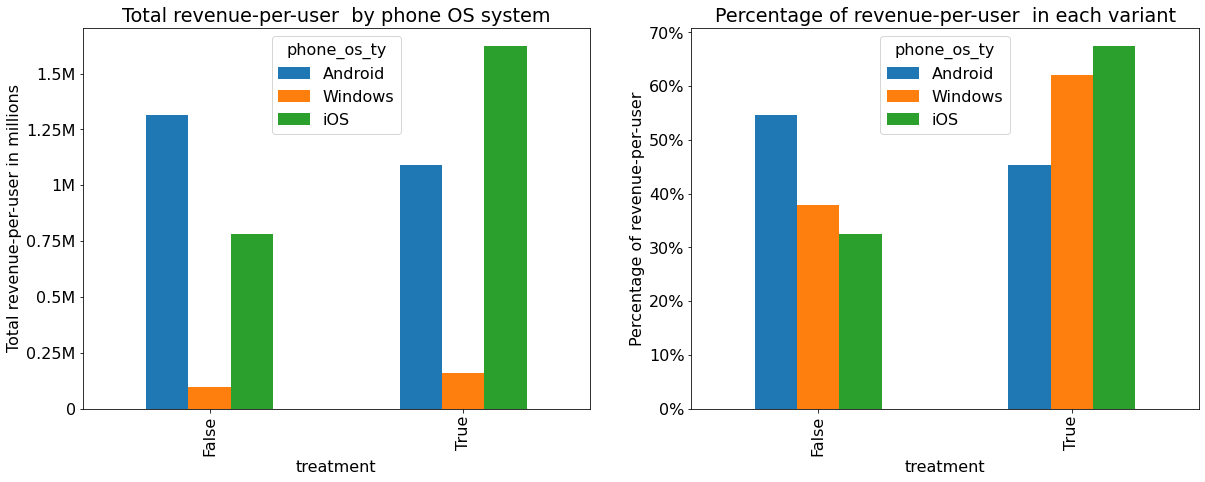

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))

# plots
p3 = pd.crosstab(values = df['revenue_per_user'],index = df['treatment'],
                 columns = df['phone_os_ty'],aggfunc = 'sum')
p4 = pd.crosstab(values = df['revenue_per_user'],index = df['treatment'],
                 columns = df['phone_os_ty'],aggfunc = 'sum',
                 normalize = 'columns')
p3.plot(kind = 'bar', ax = ax1)
p4.plot(kind = 'bar', ax = ax2)

# axes labels
label = ['0%', '10%', '20%', '30%', '40%','50%', '60%', '70%']
label_ = ['0', '0.25M', '0.5M', '0.75M', '1M', '1.25M', '1.5M']
ax1.set_title('Total revenue-per-user  by phone OS system')
ax1.set_ylabel('Total revenue-per-user in millions')
ax1.set_yticks(np.arange(0,1.6*10**6, 0.25*10**6))
ax1.set_yticklabels(label_)
ax2.set_title('Percentage of revenue-per-user  in each variant')
ax2.set_ylabel('Percentage of revenue-per-user')
ax2.set_yticklabels(label)
plt.savefig('../images/fig2.png')
plt.show()

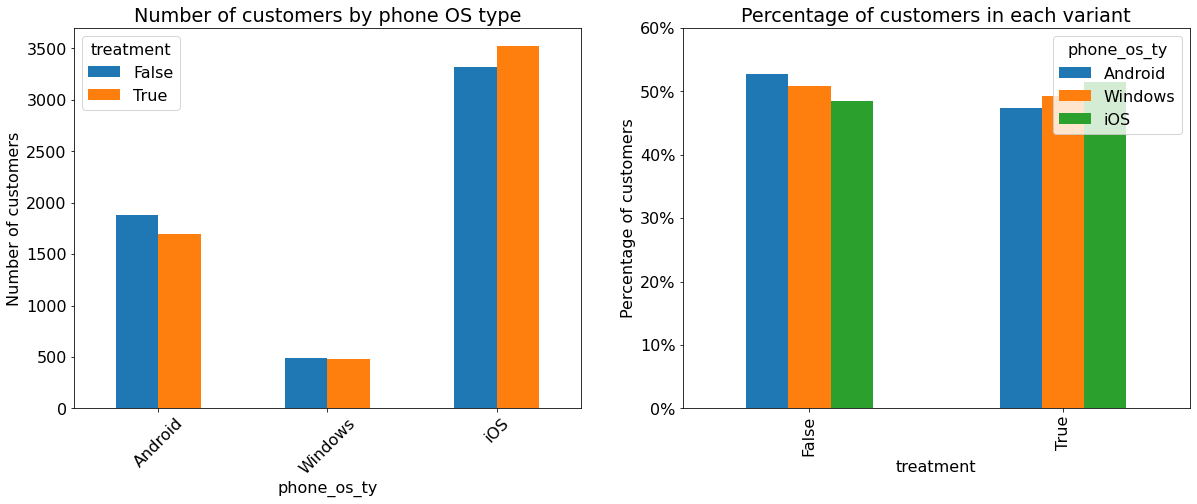

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))

# plots
p1 = df.pivot_table('revenue_per_user', index = 'phone_os_ty', 
             columns = 'treatment',aggfunc = 'count')
p2 = pd.crosstab(values = df['revenue_per_user'],index = df['treatment'],
                 columns = df['phone_os_ty'],aggfunc = 'count', 
                 normalize = 'columns')
p1.plot(kind = 'bar', ax = ax1)
p2.plot(kind = 'bar', ax = ax2)

# axes labels
label1 = ['0%', '10%', '20%', '30%', '40%', '50%', '60%']
label2 = ['Android', 'Windows', 'iOS']
ax1.set_ylabel('Number of customers')
ax1.set_xticklabels(label2, rotation = 45)
ax1.set_title('Number of customers by phone OS type')
ax2.set_ylabel('Percentage of customers')
ax2.set_yticks(np.arange(0,0.7,0.1))
ax2.set_yticklabels(label1)
ax2.set_title('Percentage of customers in each variant')
plt.savefig('../images/fig3.png')
plt.show()

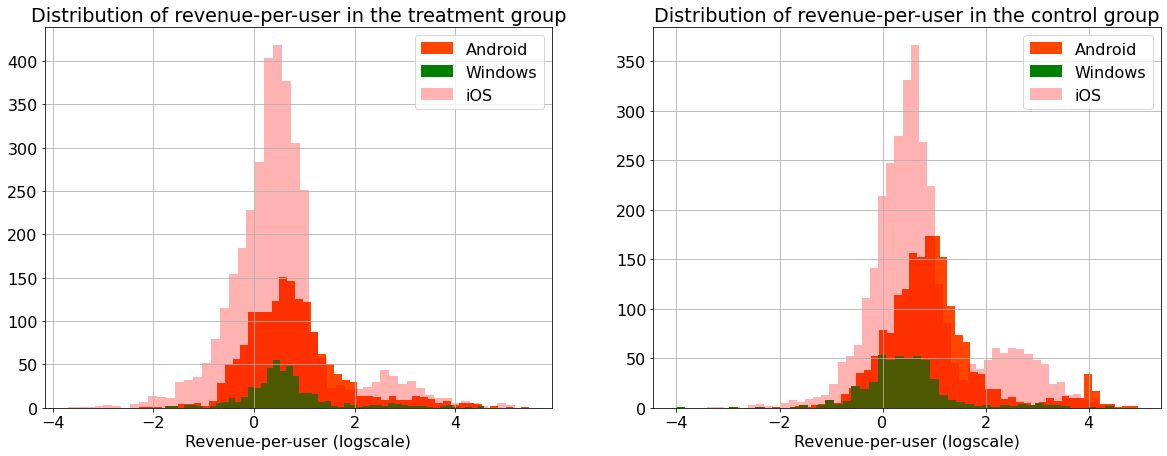

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))

# Log distribution of ARPU in treament group
np.log10(df[(df.phone_os_ty == 'Android') & (df.treatment == True)].revenue_per_user)\
.hist(bins = 50, ax = ax1, color = 'orangered', label = 'Android')
np.log10(df[(df.phone_os_ty == 'Windows')& (df.treatment == True)].revenue_per_user)\
.hist(bins = 50, ax = ax1, color = 'green', label = 'Windows')
np.log10(df[(df.phone_os_ty == 'iOS')& (df.treatment == True)].revenue_per_user)\
.hist(bins = 50, ax = ax1, alpha = 0.3, label = 'iOS',color = 'red')

# Log distribution of ARPU in control group
np.log10(df[(df.phone_os_ty == 'Android') & (df.treatment == False)].revenue_per_user)\
.hist(bins = 50, ax = ax2, color = 'orangered', label = 'Android')
np.log10(df[(df.phone_os_ty == 'Windows')& (df.treatment == False)].revenue_per_user)\
.hist(bins = 50, ax = ax2, color = 'green', label = 'Windows')
np.log10(df[(df.phone_os_ty == 'iOS')& (df.treatment == False)].revenue_per_user)\
.hist(bins = 50, ax = ax2, alpha = 0.3, label = 'iOS',color = 'red')

# axes labels
ax1.set_title('Distribution of revenue-per-user in the treatment group')
ax1.set_xlabel('Revenue-per-user (logscale)')
ax1.legend(loc = 'best')
ax2.set_title('Distribution of revenue-per-user in the control group')
ax2.set_xlabel('Revenue-per-user (logscale)')
ax2.legend(loc = 'best')
plt.savefig('../images/fig4.png')
plt.show()

# Section 2. Two-Sample Student's T-Test
In this section, I will perform a 2-sample Student's t-tests. The Student's t-test is based upon the  following assumptions:

1). Normality: The treatement and control samples were drawn from two normally distributed populations.

2). Homoscedasticity: The population variances are equal and unknown, i.e., $\sigma_1^2=\sigma_2^2=\sigma^2$.

3). Independence or stable unit treatment value assumption (SUTVA): The outcome of any unit (e.g., customer) in the experiment is not affected by the treatment of any other  unit. In other words, the treatement and control samples are independent.

Next, we formulate the hypotheses:

\begin{equation}
H_0: \mu_1 = \mu_2 \quad \text{verse}\quad H_1: \mu_1 \neq \mu_2,
\end{equation}
where $\mu_1, \mu_2$ are the two populations means.

The null hypothesis ($H_0$) states that the mean values of the two populations are the same, whereas the alternative hypothesis ($H_1$) states the mean values of the two populations are different. The goal of the hypothesis test is to decide, based on the treatment and control samples, which of the two hypotheses is true. If our result leads to the rejection of $H_0$, we conclude that there is statistically significant difference between the two populations (or samples). In other words, there is statistically significant treatement effect.

The test statistic is defined as:

$$t = \frac{\bar{x}_2-\bar{x}_1}{se(\bar{x}_2-\bar{x}_1)},$$

where $\hat{\delta} = \bar{x}_2-\bar{x}_1$ is the estimate of $\delta = \mu_2-\mu_1$, and $se(\bar{x}_2-\bar{x}_2)$ is the standard error of $\hat{\delta}$, given by

$$ se(\bar{x}_2-\bar{x}_1) = s_{\text{pooled}}\sqrt{\frac{1}{n_1}+\frac{1}{n_2}},$$

where $s_{\text{pooled}}^2$ is the pooled variance estimate of $\sigma^2$, given by
$$ s_{\text{pooled}}^2 = \frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2}.$$

Here, $s_1^2,s_2^2$ are the sample variances of the treatment and control samples (i.e., the estimate of $\sigma_1^2, \sigma_2^2$), and $n_1, n_2$ are the respective number of samples. Under the null hypothesis $H_0$, the test statistic follows a t-distribution with $n_1+n_2-2$ degrees of freedom.

We compute the p-value, which is the probability of observing a value equal to $|t|$ or larger, assuming that the null hypothesis is true. We pick a significance level $\alpha =0.05$ and if $\text{p-value} \leq  \alpha$, we conclude that the test result is statistically significant.

## 2.1. Overall treatment effect
Let's consider the overall treatment effect for all customers to determine if there is a statistically significant treatment effect. The result below shows a $\text{p-value} = 0.18 > 0.05$, which is greater that the significance level. Therefore, the data is not enough to make any conclusion overall.

In [14]:
df_contr = df[df.treatment == False] # control group
df_treat = df[df.treatment == True] # treatment group

In [15]:
# compute test-statistic and p-value
t_all, pval = stat_test.student_ttest(df_treat.revenue_per_user,
                                      df_contr.revenue_per_user)
print('The test statistic overall = {0:.6g}'.format(t_all))
print('The p-value overall = {0:.6g}'.format(pval))

The test statistic overall = 1.34089
The p-value overall = 0.179982


## 2.2. Segmented treatment effect by phone operating systems

The analysis below shows that across the three phone operating systems, only iOS has a $\text{p-value}< 0.05$. Therefore, for iOS the null hypothesis is rejected and we conclude that there is a statistically significant treatment effect. These results suggest that the new feature was effective at increasing revenue for customers using the iOS phones. For Android and Windows OS, there is not enough data to make any conclusion.

## 2.2.1. Android treatment effect

In [16]:
df_contr_android = df[(df.treatment == False) &(df.phone_os_ty == 'Android')]  # control group
df_treat_android = df[(df.treatment == True)  & (df.phone_os_ty == 'Android')] # treatment group

In [17]:
# compute test-statistic and p-value
t_android, pval = stat_test.student_ttest(df_treat_android.revenue_per_user, 
                                df_contr_android.revenue_per_user)
print('The test statistic for Android OS = {0:.6g}'.format(t_android))
print('The p-value for large Android OS = {0:.6g}'.format(pval))

The test statistic for Android OS = -0.256722
The p-value for large Android OS = 0.797408


## 2.2.2. Windows treatment effect

In [18]:
df_contr_windows = df[(df.treatment == False) &(df.phone_os_ty == 'Windows')] # control group
df_treat_windows = df[(df.treatment == True) & (df.phone_os_ty == 'Windows')] # treatment group

In [19]:
# compute test-statistic and p-value
t_windows, pval = stat_test.student_ttest(df_treat_windows.revenue_per_user,
                                df_contr_windows.revenue_per_user)
print('The test statistic for Windows OS = {0:.6g}'.format(t_windows))
print('The p-value for Windows OS = {0:.6g}'.format(pval))

The test statistic for Windows OS = 0.962203
The p-value for Windows OS = 0.336188


## 2.2.3. iOS treatment effect

In [20]:
df_contr_ios = df[(df.treatment == False) &(df.phone_os_ty == 'iOS')] # control group
df_treat_ios = df[(df.treatment == True) & (df.phone_os_ty == 'iOS')] # treatment group

In [21]:
# compute test-statistic and p-value
t_ios, pval = stat_test.student_ttest(df_treat_ios.revenue_per_user, 
                            df_contr_ios.revenue_per_user)
print('The test statistic for iOS = {0:.6g}'.format(t_ios))
print('The p-value for iOS = {0:.6g}'.format(pval))

The test statistic for iOS = 2.36338
The p-value for iOS = 0.0181371


# Section 3. Two-Sample Welch's T-Test
In this section, I will perform a 2-sample Welch's t-tests. The Welch's t-test is based upon the following assumptions:

1). Normality: The treatement and control samples were drawn from two normally distributed populations.

2). Heteroscedasticity: The population variances are not equal, and they are unknown, i.e., $\sigma_1^2\neq \sigma_2^2$. 

3). Independence or stable unit treatment value assumption (SUTVA): The outcome of any unit (e.g., customer) in the experiment is not affected by the treatment of any other  unit. In other words, the treatement and control samples are independent.

The hypotheses statements are the same as in Section 2, but the standard error in the  test statistic is now defined as

$$ se(\bar{x}_2-\bar{x}_1) = \sqrt{\frac{s_1^2}{n_1}+\frac{s_1^2}{n_2}},$$

where $s_1^2,s_2^2$ are the sample variances of the treatment and control samples (i.e., the estimate of $\sigma_1^2, \sigma_2^2$), and $n_1, n_2$ are the respective number of samples.

The exact distribution of test statistic in this case is  very complex. However, it can be approximated to a t-distribution with $\nu$ degrees of freedom,  given by

\begin{equation}
\nu \approx \frac{\Big(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}\Big)^2}{\frac{s_1^4}{n_1^2(n_1-1)} + \frac{s_2^4}{n_2^2(n_2-1)}}.
\end{equation}

Note that $\nu$ is generally non-integer unlike the Student's degrees of freedom. 

## 3.1. Overall treatment effect
Due to large sample size, the Student's and Welch's t-tests yield similar results and the same conclusion. That is $\text{p-value} = 0.18 > 0.05$. Therefore, the data is not enough to make any conclusion overall.

In [22]:
# compute test-statistic and p-value
t_all, pval = stat_test.welch_ttest(df_treat.revenue_per_user,
                                      df_contr.revenue_per_user)
print('The test statistic overall = {0:.6g}'.format(t_all))
print('The p-value overall = {0:.6g}'.format(pval))

The test statistic overall = 1.34089
The p-value overall = 0.179995


## 3.2. Segmented treatment effect by phone operating systems
Here, I reached the same conclusion as in the Student's t-test.

## 3.2.1. Android treatment effect

In [23]:
# compute test-statistic and p-value
t_android, pval = stat_test.welch_ttest(df_treat_android.revenue_per_user, 
                                df_contr_android.revenue_per_user)
print('The test statistic for Android OS = {0:.6g}'.format(t_android))
print('The p-value for large Android OS = {0:.6g}'.format(pval))

The test statistic for Android OS = -0.248985
The p-value for large Android OS = 0.803393


## 3.2.2. Windows treatment effect

In [24]:
# compute test-statistic and p-value
t_windows, pval = stat_test.welch_ttest(df_treat_windows.revenue_per_user,
                                df_contr_windows.revenue_per_user)
print('The test statistic for Windows OS = {0:.6g}'.format(t_windows))
print('The p-value for Windows OS = {0:.6g}'.format(pval))

The test statistic for Windows OS = 0.957107
The p-value for Windows OS = 0.338785


## 3.2.3. iOS treatment effect

In [25]:
# compute test-statistic and p-value
t_ios, pval = stat_test.welch_ttest(df_treat_ios.revenue_per_user, 
                            df_contr_ios.revenue_per_user)
print('The test statistic for iOS = {0:.6g}'.format(t_ios))
print('The p-value for iOS = {0:.6g}'.format(pval))

The test statistic for iOS = 2.42672
The p-value for iOS = 0.0152799


# Section 4. The Mann-Whitney U Test
The parametric t-tests (Student and Welch) used above made some assumptions in advance about the population from which the treatment and control samples were drawn. Clearly, we can saw that those assumptions were not valid in the current sample data. Therefore, we should resort to a non-parameter test in which there is no assumption about nature of the population from which the treatment and control samples were drawn. However, we still require that SUTVA or indenpendence assumption holds. 

The Mann-Whitney U Test is a good non-parameter test to use. The U statistic is defined as

$$
U_1 = n_1n_2 + \frac{ n_1(n_1+1)}{2} - R_1 \quad \text{and} \quad
U_2 = n_1n_2 + \frac{ n_2(n_2+1)}{2} - R_2,
$$

where  $R_1$ is the sum of the ranks  assigned to sample 1 (i.e., sum of the indexes assigned to the observations after sorting the combined samples), and $R_2$ is the sum of the ranks assigned to sample 2. Here, $U_1$  is the  number of times an  $x_1^i$ from sample 1 is greater than an  $x_2^i$ from sample 2. Similarly,  $U_2$  is the  number of times an  $x_1^i$ from sample 1 is smaller than an  $x_2^i$  from sample 2.

Due to large sample sizes in the present problem, a normal approximation can be used by defining:

$$
\mu_U = \frac{n_1n_2}{2},\quad \sigma_U =\sqrt{\Big(  \frac{n_1n_2}{N\big(N-1\big)}\Big)\Big(  \frac{N^3 -N}{12} - \sum_{j}^{n_s}\frac{t_j^3-t_j}{12}\Big) },
$$

where $\mu_U$  and $\sigma_U$ are the mean and standard deviation of  the $U$ distribution respectively,   $n_s$ is the number of samples in which ties occur, and $t_j$ is the number of observations tied for a given rank in sample $j$. In the absence of ties $t =0$. 

The corresponding test statistic is given by

$$
z = \frac{U -\mu_U}{\sigma_U},
$$

where $z\sim N(0,1)$. In the normal approximation, the computation of $U$ can be done by either $U_1$ or $U_2$,  because $|z|$ is the same whether  $U_1$ or $U_2$ is used in computing $U$.

The p-value  is calculated from the standard normal distribution under $H_0$, given by

$$
\text{p-value} = P\Big(|Z|\geq |z|\Big\vert Z = N(0,1)\Big)
= 2P\Big(Z< -|z|\Big\vert Z = N(0,1)\Big)
= 2\Phi(-|z|),
$$

where $\Phi$ is the CDF of normal distribution.

## 4.1. Overall treatment effect
In the Mann-Whitney u-test, the overrall $\text{p-value} = 1.1\times 10^{-36} \ll 0.05$. This shows a very strong evidence against the null hypothesis. Therefore, we reject the null the hypothesis, and conclude that the result is statistically significant. 

In [26]:
# compute U-statistic and p-value
ux, pval = stat_test.mann_whitney_utest(df_treat.revenue_per_user,
                                      df_contr.revenue_per_user)

nx = len(df_treat.revenue_per_user) # number of treatment samples
ny = len(df_contr.revenue_per_user) # number of control samples

uy = nx*ny -ux # compute uy

print('Ux statistic overall = {0:.6g}'.format(ux))
print('Uy statistic overall = {0:.6g}'.format(uy))
print('p-value overall = {0:.6g}'.format(pval))

Ux statistic overall = 1.40009e+07
Uy statistic overall = 1.84208e+07
p-value overall = 1.07846e-36


## 4.2. Segmented treatment effect by phone operating systems

Across all phone operating systems, the Mann-Whitney u-test yields a $\text{p-value} \ll 0.05$. This shows a very strong evidence against the null hypothesis. Therefore, we reject the null the hypothesis, and conclude that the result is statistically significant. 

## 4.2.1.  Android treatment effect

In [27]:
# compute U-statistic and p-value
ux, pval = stat_test.mann_whitney_utest(df_treat_android.revenue_per_user,
                                      df_contr_android.revenue_per_user)

nx = len(df_treat_android.revenue_per_user) # number of treatment samples
ny = len(df_contr_android.revenue_per_user) # number of control samples

uy = nx*ny -ux # compute uy

print('Ux statistic Android OS = {0:.6g}'.format(ux))
print('Uy statistic Android OS = {0:.6g}'.format(uy))
print('p-value Android OS = {0:.6g}'.format(pval))

Ux statistic Android OS = 1.37208e+06
Uy statistic Android OS = 1.81227e+06
p-value Android OS = 4.47263e-13


## 4.2.2. Windows treatment effect

In [28]:
# compute U-statistic and p-value
ux, pval = stat_test.mann_whitney_utest(df_treat_windows.revenue_per_user,
                                      df_contr_windows.revenue_per_user)

nx = len(df_treat_windows.revenue_per_user) # number of treatment samples
ny = len(df_contr_windows.revenue_per_user) # number of control samples

uy = nx*ny-ux # compute uy

print('Ux statistic Windows OS = {0:.6g}'.format(ux))
print('Uy statistic Windows OS = {0:.6g}'.format(uy))
print('p-value Windows OS = {0:.6g}'.format(pval))

Ux statistic Windows OS = 102832
Uy statistic Windows OS = 132822
p-value Windows OS = 0.000299532


## 4.2.3. iOS treatment effect

In [29]:
# compute U-statistic and p-value
ux, pval = stat_test.mann_whitney_utest(df_treat_ios.revenue_per_user,
                                      df_contr_ios.revenue_per_user)

nx = len(df_treat_ios.revenue_per_user) # number of treatment samples
ny = len(df_contr_ios.revenue_per_user) # number of control samples

uy = nx*ny -ux # compute uy
print('Ux statistic iOS = {0:.6g}'.format(ux))
print('Uy statistic iOS = {0:.6g}'.format(uy))
print('p-value iOS = {0:.6g}'.format(pval))

Ux statistic iOS = 4.93835e+06
Uy statistic iOS = 6.7578e+06
p-value iOS = 4.07698e-29


# Conclusion

In this project, I examined the problem of testing if a new feature introduced by an e-commerce company through their mobile app will increase revenue.  Through data exploration, I showed that different segmentations of phone operating systems show heterogeneity in the treatment and control groups. Moveover, the revenue-per-user is highly skewed to the right, because some customers spent more than others.

Three statistical tests were conducted. The parametric t-tests (Student and Welch) did not give enough evidence against the null hypothesis. Therefore, I concluded that the data is not enough to support any conclusion. By looking at different segmentation of the data, I established a statistically significant treatment effect for iOS customers, with $\text{p-value}=0.012$.

From the data exploration, it is evident that the assumptions of the Student's and the Welch's t-tests were not valid, therefore the Mann-Whitney u-test was performed. The Mann-Whitney u-test shows a very strong evidence against the null hypothesis both overall and by segmentation. Therefore, the null hypothesis was rejected and I conlcuded that there is a statistically significant treatment effect. Hence, the new feature shows improvement in revenue and the e-commerce company can go ahead and lunch it to all their customers.